In [1]:
import pandas as pd
import numpy as np
import torch
from utilities import *
from sklearn.preprocessing import StandardScaler

torch.set_default_dtype(torch.float64)

# https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17
data = pd.read_csv("data/star_classification.csv")

def one_hot(array):
    unique, inverse = np.unique(array, return_inverse=True)
    onehot = np.eye(unique.shape[0])[inverse]
    return onehot

In [2]:
data

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


In [3]:
data["class"].unique()

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

In [4]:
msk = np.random.rand(len(data)) < 0.8
xcols = ["alpha", "delta", "u", "g", "r", "i", "z", "redshift"]
ycol = "class"
classes = len(data[ycol].unique())
train = data[msk]
test = data[~msk]
print(len(train), " ",len(test))

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(train[xcols].values)
X_train = torch.tensor(scaler.transform(train[xcols].values))
y_train = torch.tensor(one_hot(train[ycol].values))
X_test = torch.tensor(scaler.transform(test[xcols].values))
y_test = torch.tensor(one_hot(test[ycol].values))

# Creating our dataset class
class BuildData(torch.utils.data.Dataset):    
    # Constructor
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.len = len(self.x)        
    # Getting the data
    def __getitem__(self, index):    
        return self.x[index], self.y[index]    
    # Getting length of the data
    def __len__(self):
        return self.len

train_dataset = BuildData(X_train, y_train)
test_dataset = BuildData(X_test, y_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = 200)#, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = 100)

79892   20108


In [5]:
y_train

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])

In [6]:
for x,y in test_loader:
    print(x,y)
    break

tensor([[ 2.3394e-01,  1.1784e+00,  6.9013e-02,  5.2228e-02,  5.2154e-01,
          2.1596e-01,  8.8209e-03,  1.1109e-01],
        [ 1.8150e+00, -1.0692e+00,  7.3124e-02,  2.6486e-02,  7.0654e-01,
          9.7165e-01,  5.1821e-02, -7.8890e-01],
        [-5.8828e-02,  2.2252e+00,  5.1368e-03,  9.7296e-03, -3.6611e-01,
         -4.3693e-01, -1.8719e-02, -2.7763e-01],
        [-3.3492e-01,  1.1662e+00,  9.8276e-02,  7.5486e-03,  9.6424e-03,
         -2.1597e-04,  5.2487e-03,  1.1422e-01],
        [-3.8323e-01, -9.5791e-01,  9.8933e-02,  5.3631e-02,  9.6606e-01,
          6.6963e-01,  3.7825e-02,  4.4383e-02],
        [ 7.7643e-01, -2.3307e-01,  6.7820e-02, -3.5079e-03, -5.9893e-01,
         -7.0818e-01, -3.3829e-02, -2.6418e-01],
        [ 2.1026e-02,  4.8932e-01,  3.7400e-02, -4.1661e-03, -4.5653e-01,
         -5.3896e-01, -2.5498e-02, -4.2022e-01],
        [-1.4152e+00, -1.0446e+00,  2.3686e-02,  5.0513e-02,  1.4001e+00,
          1.4057e+00,  6.6709e-02,  6.6417e-01],
        [ 6.2886

In [7]:
for x,y in train_loader:
    print(x,y)
    break

tensor([[-0.4340,  0.4293,  0.0543,  ...,  0.0458,  0.0042,  0.0767],
        [-0.3395,  0.3671,  0.0796,  ...,  1.1847,  0.0837,  0.2734],
        [-0.3668,  0.5866,  0.0932,  ...,  0.1498,  0.0085,  0.0895],
        ...,
        [-1.5887, -0.2713,  0.0107,  ...,  1.0998,  0.0470,  1.5442],
        [ 0.0024,  1.5339, -0.0734,  ..., -1.0327, -0.0440, -0.7176],
        [-0.1556,  1.4344, -0.0754,  ..., -0.9712, -0.0395, -0.6990]]) tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0.,

In [14]:
class Classifier(torch.nn.Module):
    def __init__(self, atomics=False):
        super(Classifier, self).__init__()
        if atomics:
            self.layer0 = AtomicLinear(len(xcols), 5*len(xcols))
            self.layer1 = AtomicLinear(5*len(xcols), 5*len(xcols))
            self.layer2 = AtomicLinear(5*len(xcols), classes)

        else:
            self.layer0 = torch.nn.Linear(len(xcols),5*len(xcols))
            self.layer1 = torch.nn.Linear(5*len(xcols),5*len(xcols))
            self.layer2 = torch.nn.Linear(5*len(xcols),classes)
        
        self.norm1 = torch.nn.BatchNorm1d(5*len(xcols))
        self.norm2 = torch.nn.BatchNorm1d(5*len(xcols))
        self.activation = torch.nn.ReLU()
        self.probs = torch.nn.Softmax()
        assign_fixed_params(self)

    def forward(self,x):
        y0 = self.norm1(self.activation(self.layer0(x)))
        y1 = self.norm2(self.activation(self.layer1(y0)))
        y2 = self.layer2(y1)
        return y2
        #return self.probs(y1)

class ClassifierTest(torch.nn.Module):
    def __init__(self, atomics=False):
        super(ClassifierTest, self).__init__()
        self.layer0 = AtomicLinearTest(len(xcols), 5*len(xcols))
        self.layer1 = AtomicLinearTest(5*len(xcols), 5*len(xcols))
        self.layer2 = AtomicLinearTest(5*len(xcols), classes)
        
        self.norm1 = torch.nn.BatchNorm1d(5*len(xcols))
        self.norm2 = torch.nn.BatchNorm1d(5*len(xcols))
        self.activation = torch.nn.ReLU()
        self.probs = torch.nn.Softmax()
        assign_fixed_params(self)

    def forward(self,x):
        y0 = self.norm1(self.activation(self.layer0(x)))
        y1 = self.norm2(self.activation(self.layer1(y0)))
        y2 = self.layer2(y1)
        return y2
        #return self.probs(y1)

def train(model, dataloader, criterion, optimizer):
    model.train()
    for x,y in dataloader:
        optimizer.zero_grad()
        y_logits = model(x)
        _, classtype = torch.max(y,1)
        loss = criterion(y_logits, classtype)
        loss.backward()
        optimizer.step()
    #print(loss)
    #for param in model.parameters():
    #    print(param.grad)
    return loss

def test(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in dataloader:
            prediction_prob = model(data)
            prediction = torch.argmax(prediction_prob, dim=1)
            target = torch.argmax(target, dim=1)
            for i in range(len(prediction)):
                if prediction[i]==target[i]:
                    correct+=1
                total+=1
    return correct, total

In [9]:
model = Classifier(atomics=True)
model2 = Classifier()
model.eval()
model2.eval()
x,y = next(iter(train_loader))
print(x.shape)
#print(x,y)
#print(model(x), y)
print(len(x))
y1 = model(x)
y2 = model2(x)
#print(loss)

torch.Size([200, 8])
200


In [10]:
torch.allclose(y1,y2)

True

In [16]:
model = Classifier()
correct,total = test(model, test_loader)
print(f"{100*(correct/total):.2f}%")

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

losses = []
for epoch in range(40):
    losses.append(train(model, train_loader, criterion, optimizer))
    correct,total = test(model, test_loader)
    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print(f"{100*(correct/total):.2f}%  lr: {before_lr:.1E}->{after_lr:.1E}")

27.90%
91.92%  lr: 1.0E-01->1.0E-01
94.57%  lr: 1.0E-01->1.0E-01
94.50%  lr: 1.0E-01->1.0E-01
94.26%  lr: 1.0E-01->1.0E-01
94.77%  lr: 1.0E-01->1.0E-01
94.05%  lr: 1.0E-01->1.0E-01
94.21%  lr: 1.0E-01->1.0E-01
93.76%  lr: 1.0E-01->1.0E-01
93.84%  lr: 1.0E-01->1.0E-01
93.97%  lr: 1.0E-01->1.0E-02
96.72%  lr: 1.0E-02->1.0E-02
96.75%  lr: 1.0E-02->1.0E-02
96.77%  lr: 1.0E-02->1.0E-02
96.79%  lr: 1.0E-02->1.0E-02


KeyboardInterrupt: 

In [17]:
model = Classifier()
correct,total = test(model, test_loader)
print(f"{100*(correct/total):.2f}%")

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

losses = []
for epoch in range(40):
    losses.append(train(model, train_loader, criterion, optimizer))
    correct,total = test(model, test_loader)
    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print(f"{100*(correct/total):.2f}%  lr: {before_lr:.1E}->{after_lr:.1E}")

27.90%
91.92%  lr: 1.0E-01->1.0E-01
94.57%  lr: 1.0E-01->1.0E-01
94.50%  lr: 1.0E-01->1.0E-01


KeyboardInterrupt: 

In [18]:
model = ClassifierTest()
correct,total = test(model, test_loader)
print(f"{100*(correct/total):.2f}%")
tomicLinear
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

losses = []
for epoch in range(40):
    losses.append(train(model, train_loader, criterion, optimizer))
    correct,total = test(model, test_loader)
    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print(f"{100*(correct/total):.2f}%  lr: {before_lr:.1E}->{after_lr:.1E}")

27.90%
91.92%  lr: 1.0E-01->1.0E-01
94.57%  lr: 1.0E-01->1.0E-01


KeyboardInterrupt: 

In [22]:
model2 = Classifier(atomics=True)
correct,total = test(model2, test_loader)
print(f"{100*(correct/total):.2f}%")

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

losses2 = []
for epoch in range(40):
    losses2.append(train(model2, train_loader, criterion, optimizer))
    correct,total = test(model2, test_loader)
    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print(f"{100*(correct/total):.2f}%  lr: {before_lr:.1E}->{after_lr:.1E}")

23.98%
88.15%  lr: 1.0E-01->1.0E-01
90.96%  lr: 1.0E-01->1.0E-01
93.68%  lr: 1.0E-01->1.0E-01
94.67%  lr: 1.0E-01->1.0E-01
95.65%  lr: 1.0E-01->1.0E-01
95.32%  lr: 1.0E-01->1.0E-01
96.31%  lr: 1.0E-01->1.0E-01
95.22%  lr: 1.0E-01->1.0E-01
94.96%  lr: 1.0E-01->1.0E-01
95.32%  lr: 1.0E-01->1.0E-02
96.59%  lr: 1.0E-02->1.0E-02
96.65%  lr: 1.0E-02->1.0E-02
96.73%  lr: 1.0E-02->1.0E-02
96.78%  lr: 1.0E-02->1.0E-02
96.63%  lr: 1.0E-02->1.0E-02
96.60%  lr: 1.0E-02->1.0E-02
96.54%  lr: 1.0E-02->1.0E-02
96.53%  lr: 1.0E-02->1.0E-02
96.52%  lr: 1.0E-02->1.0E-02
96.50%  lr: 1.0E-02->1.0E-03
96.83%  lr: 1.0E-03->1.0E-03
96.84%  lr: 1.0E-03->1.0E-03
96.84%  lr: 1.0E-03->1.0E-03
96.86%  lr: 1.0E-03->1.0E-03
96.87%  lr: 1.0E-03->1.0E-03
96.86%  lr: 1.0E-03->1.0E-03
96.88%  lr: 1.0E-03->1.0E-03
96.88%  lr: 1.0E-03->1.0E-03
96.89%  lr: 1.0E-03->1.0E-03
96.89%  lr: 1.0E-03->1.0E-04
96.93%  lr: 1.0E-04->1.0E-04
96.93%  lr: 1.0E-04->1.0E-04
96.93%  lr: 1.0E-04->1.0E-04
96.93%  lr: 1.0E-04->1.0E-04
96.93% 

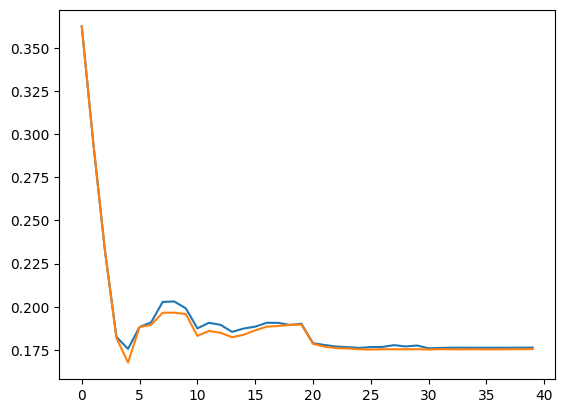

In [28]:
import matplotlib.pyplot as plt
losses = [l.item() for l in losses]
losses2 = [l.item() for l in losses2]
plt.plot([i for i in range(len(losses))],losses)
plt.plot([i for i in range(len(losses2))],losses2)
plt.show()

In [30]:
all_losses = []
for i in range(10):
    model = Classifier(atomics=True)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    losses = []
    for epoch in range(20):
        losses.append(train(model, train_loader, criterion, optimizer).item())
        correct,total = test(model, test_loader)
        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        
    print(f"Model {i} trained with {100*(correct/total):.2f}% accuracy")
    all_losses.append(losses)
    

Model 0 trained with 96.59% accuracy
Model 1 trained with 96.59% accuracy
Model 2 trained with 96.60% accuracy
Model 3 trained with 96.57% accuracy
Model 4 trained with 96.59% accuracy
Model 5 trained with 96.59% accuracy
Model 6 trained with 96.59% accuracy
Model 7 trained with 96.59% accuracy
Model 8 trained with 96.59% accuracy
Model 9 trained with 96.59% accuracy


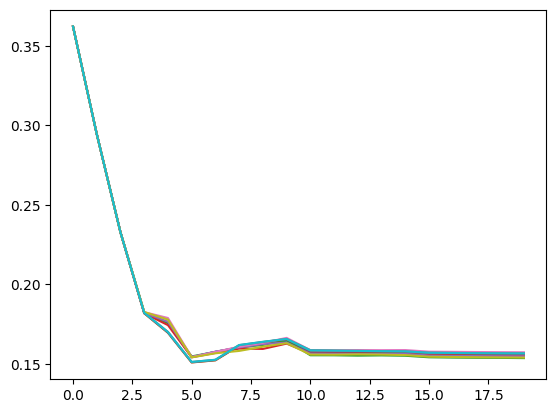

In [31]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.plot([i for i in range(len(all_losses[i]))],all_losses[i])
plt.show()

## Attack the networks

* Pick an attack like gradient
* epsilon sized attack
* P(missclassificatoin) vs R^Features radius


Find x1 classed as GALAXY
Find x2 classed as STAR

find where it switches in R^Features up to some ( $\delta$ FP precision...), try raidus $r$ for classification change.



https://adversarial-ml-tutorial.org/linear_models/

can try with my linear layer too see what happens!
